# **I. Data**

In [2]:
data_path = "/Linux/Odor/DAT/"
output_path = "/Linux/Odor/OUT/"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score
import seaborn as sns

### 직접 생성한 패키지
from My_code.Odor_Analysis import Odor
from My_code.Metrics import R2, MAPE

In [4]:
### 원 데이터
odor = pd.read_csv(data_path + "New_data2.csv", encoding="euc-kr")
odor = odor.drop(["yy", "mm", "dd", "farm"], axis = 1)    # 불필요한 변수 제거
odor.rename(columns = {"mm.1" : "mm"}, inplace = True)    # 추후 변수명을 편하게 사용하기 위해
print(odor.shape)
display(odor.head())

(57, 16)


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,NaN,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,NaN,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92
3,2080,1.02,344.0,NaN,13.0,0.63,490.79,570.61,51.09,719.27,168.48,237.64,8.90,60.56,5.55,7.31
4,310,1.18,312.0,NaN,NaN,NaN,404.53,468.03,43.17,573.75,157.22,205.67,9.21,69.90,NaN,5.43


In [5]:
### 결측값 확인
num_na = odor.isna().sum().sum()


print("NA 개수 :", num_na) #, " ND 개수 :",  num_nd)
na = pd.DataFrame(odor.isna().sum(), columns = ["NA"]).transpose()
na_per = np.round(na/odor.shape[0], 3)
na_per.index = ["NA (%)"]

na_df = pd.concat([na, na_per], axis = 0)
na_df

NA 개수 : 155


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
NA,0.0,0.0,0.0,31.000,36.000,52.000,0.0,1.000,1.000,1.000,0.0,1.000,2.000,1.000,21.000,8.00
NA (%),0.0,0.0,0.0,0.544,0.632,0.912,0.0,0.018,0.018,0.018,0.0,0.018,0.035,0.018,0.368,0.14


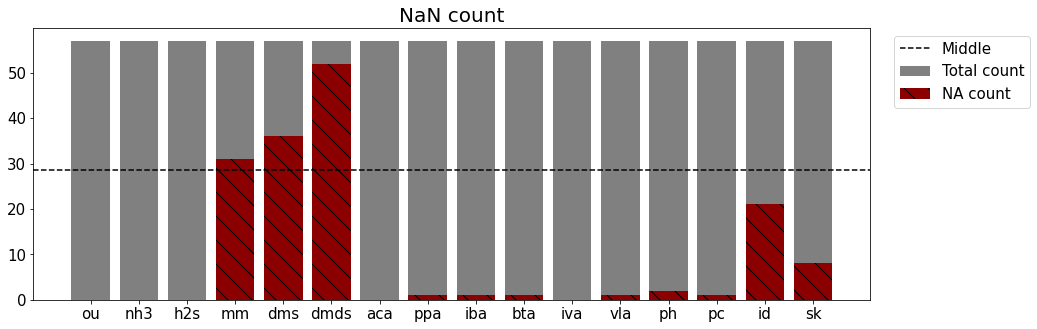

In [6]:
import matplotlib.pyplot as plt

total = odor.count()+odor.isna().sum()

plt.figure(figsize = (15, 5))
plt.bar(odor.columns, total, label = "Total count", color = "grey")
plt.bar(odor.columns, odor.isna().sum(), label = "NA count", color = "darkred", hatch = "\\")
plt.axhline(total[0]/2, linestyle = "--", color = "black")
plt.xticks(fontsize = 15) ; plt.yticks(fontsize = 15)
plt.legend(loc = "upper right", labels = ["Middle", "Total count", "NA count"], 
           bbox_to_anchor=(1.2, 1), fontsize = 15)
plt.title("NaN count", fontsize = 20)
plt.show()

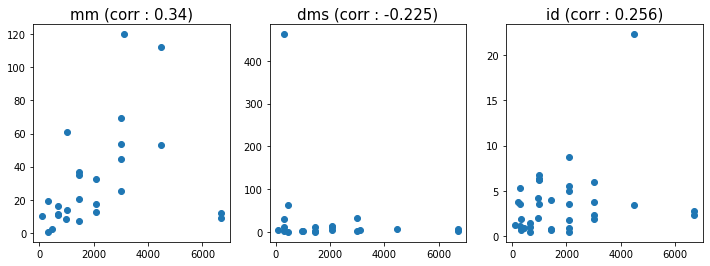

In [6]:
test_variables = ["mm", "dms", "id"]

plt.figure(figsize = (12, 4))
for i in range(len(test_variables)) :
    test_df = odor.loc[:, ["ou", test_variables[i]]].dropna()
    plt.subplot(1,3,i+1)
    corr = np.round(np.corrcoef(test_df.loc[:, "ou"], test_df.loc[:, test_variables[i]])[0,1], 3)
    plt.scatter(odor.loc[:, "ou"], odor.loc[:, test_variables[i]])
    plt.title(test_variables[i] + " (corr : " + str(corr) + ")", fontsize = 15)
    

plt.show()

In [7]:
odor2 = odor.drop(columns = ["dmds"])
print(odor2.shape)
odor2.head(3)

(57, 15)


,ou,nh3,h2s,mm,dms,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


# **Result**

- 나눠서 하는것이 좋음

In [8]:
Missings = ["Simple(Mean) Imp", "Simple(Median) Imp",
            "Multivariate(BayesianRidge) Imp", "Multivariate(ExtraTree) Imp", 
            "Multiple(BayesianRidge) Imp", "Multiple(GaussianProcessRegressor) Imp",
            "KNN Imp"]
Variables = ["None", "PLS", "PCA"]
Models = ["Regression", "SVR", "Random Forest", "Extra Tree", "XGboost", "DNN"]

In [9]:
from tqdm.notebook import tqdm

preds_df = pd.DataFrame(index = range(0, 57))

for i in tqdm(range(len(Missings))) :
  for j in range(len(Variables)) :
    for k in range(len(Models)) :
      result = Odor(data = odor2, missing = Missings[i], Variable = Variables[j], Model = Models[k])

      pred = result["prediction"]
      pred_df = pd.DataFrame(pred, columns = [Missings[i] + "_" + Variables[j] + "_" + Models[k]])
      preds_df = pd.concat([preds_df, pred_df], axis = 1)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [10]:
display(preds_df.head(3))
display(preds_df.tail(3))
print(preds_df.shape)
preds_df.to_csv(output_path + "Prediction results (논문용).csv", index = False)

,KNN Imp_None_SVR,Multivariate(ExtraTree) Imp_None_SVR
0,689.776,638.616
1,2004.691,2074.201
2,1577.005,1065.624


,KNN Imp_None_SVR,Multivariate(ExtraTree) Imp_None_SVR
54,2778.504,2322.734
55,1766.530,1631.389
56,1753.836,1958.350


(57, 2)


In [24]:
# preds_df_papaer.to_csv(output_path + "Prediction results (논문용).csv", index = False)
results = pd.read_csv(output_path + "Prediction results (논문용).csv")
results

,Simple(Mean) Imp_None_Regression,Simple(Mean) Imp_None_Random Forest,Simple(Mean) Imp_None_Extra Tree,Simple(Mean) Imp_None_XGboost,Simple(Mean) Imp_None_DNN,Simple(Mean) Imp_PLS_Regression,Simple(Mean) Imp_PLS_Random Forest,Simple(Mean) Imp_PLS_Extra Tree,Simple(Mean) Imp_PLS_XGboost,Simple(Mean) Imp_PLS_DNN,...,KNN Imp_PLS_Regression,KNN Imp_PLS_Random Forest,KNN Imp_PLS_Extra Tree,KNN Imp_PLS_XGboost,KNN Imp_PLS_DNN,KNN Imp_PCA_Regression,KNN Imp_PCA_Random Forest,KNN Imp_PCA_Extra Tree,KNN Imp_PCA_XGboost,KNN Imp_PCA_DNN
0,2258.047,761.93,1165.41,644.556030,1644.542969,1204.443,2199.30,2083.80,1608.993042,1676.155029,...,935.560,356.00,300.00,312.276001,1684.176025,572.043,530.76,608.97,528.776978,1584.336060
1,-15957.322,1657.74,1431.90,1370.485962,426.372009,8.498,635.25,669.00,624.158020,2348.813965,...,-4009.103,755.79,763.58,784.784973,1576.232056,-5630.504,1483.14,1488.45,1008.890991,1433.990967
2,1576.157,867.90,1167.71,788.434998,2016.469971,1729.407,1603.50,1162.00,1600.812012,1621.806030,...,1738.093,2267.54,2080.00,2490.281006,1657.422974,1838.763,2108.77,2349.81,1538.160034,1311.602051
3,1912.066,519.88,786.25,515.721985,1849.941040,1643.436,572.76,397.68,693.849976,1476.683960,...,1693.263,1653.42,986.42,1644.624023,1599.949951,2541.428,835.54,1032.67,621.843018,1833.136963
4,1750.893,945.33,963.54,981.526001,1560.010010,1566.204,1416.50,1424.80,1181.552002,1493.904053,...,1455.917,955.24,1000.00,854.632996,1464.201050,1428.842,785.94,593.32,650.161011,1318.683960
5,2003.987,600.25,678.92,643.202026,1441.078979,1480.150,1171.15,1000.00,1366.682983,1472.439941,...,1376.727,777.97,669.00,1034.227051,1480.496948,1604.432,665.38,638.14,544.817017,1539.442017
6,1763.527,516.33,523.91,542.935974,1539.939941,1547.531,1036.93,380.80,1255.114990,1488.796021,...,1429.070,793.56,917.25,713.265991,1468.011963,1231.406,608.90,683.60,575.848022,1248.284058
7,2096.493,1424.34,1427.16,1426.625000,1607.927002,1649.904,1591.12,1443.52,1246.473999,1490.859985,...,1596.548,1468.48,952.48,1140.590942,1486.782959,1671.585,976.05,1012.27,1190.425049,1356.159058
8,1236.407,788.07,573.75,668.999023,1474.562012,1494.649,3129.12,4028.47,2590.774902,1450.624023,...,1564.681,995.88,1129.60,847.887024,1452.952026,2093.943,1101.95,1294.69,1039.994019,1527.484009
9,1238.384,1146.40,1084.74,1275.996948,1362.432983,1453.858,1615.66,1520.00,1468.910034,1488.016968,...,1355.797,1577.65,1515.60,1287.359009,1487.364990,1129.676,737.44,591.24,649.909973,1318.400024
